In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
results_path = "../reports"

model_list = ["UNet++", "AttentionUNet", "UNet", "VNet", "NoSkipUNet", "NoSkipVNet"]
model_alias = {"UNet++": "UNet++", "AttentionUNet": "AGU-Net", "UNet": "U-Net", "VNet": "V-Net", "NoSkipUNet": "NoSkipU-Net", "NoSkipVNet": "NoSkipV-Net"}

anatomy_list = ["BUSI", "GLaS", "Heart", "Spleen"]
anatomy_alias = {"BUSI": "Breast \n (Ultrasound)", "GLaS": "Colon \n (Histology)", "Heart": "Heart \n (MRI)", "Spleen": "Spleen \n (CT)"}

variant_list = ["lower", "low", "in-domain", "high", "higher"]
variant_alias = {"lower": "Hardest", "low": "Harder", "in-domain": "Unperturbed", "high": "Easier", "higher": "Easiest"}

In [3]:
sdsc_mean_data = {}
sdsc_std_data = {}

for texture_variant in ["lower", "low", "in-domain", "high", "higher"]:
    sdsc_mean = pd.DataFrame(columns=model_list,
                    index=anatomy_list)

    sdsc_sd = pd.DataFrame(columns=model_list,
                    index=anatomy_list)

    for anatomy in anatomy_list:
        for model_name in model_list:
            result_seed_1 = os.path.join(results_path, anatomy + "-results", anatomy + "_stats_" + model_name + "_" + texture_variant + "_256_1.csv")
            result_seed_2 = os.path.join(results_path, anatomy + "-results", anatomy + "_stats_" + model_name + "_" + texture_variant + "_256_2.csv")
            result_seed_3 = os.path.join(results_path, anatomy + "-results", anatomy + "_stats_" + model_name + "_" + texture_variant + "_256_3.csv")

            seed_1_data = pd.read_csv(result_seed_1)
            seed_1_data = seed_1_data.loc[seed_1_data['Set'] == "test"]

            seed_2_data = pd.read_csv(result_seed_2)
            seed_2_data = seed_2_data.loc[seed_2_data['Set'] == "test"]

            seed_3_data = pd.read_csv(result_seed_3)
            seed_3_data = seed_3_data.loc[seed_3_data['Set'] == "test"]

            sdsc_scores = np.hstack((seed_1_data["SurfaceDSC"].to_numpy(), seed_2_data["SurfaceDSC"].to_numpy(), seed_3_data["SurfaceDSC"].to_numpy()))
            sdsc_scores[~np.isfinite(sdsc_scores)] = np.sqrt(2) * 256

            #print("For anatomy: " + anatomy + " and model: " + model_name + " and texture: " + texture_variant + ", sdsc mean: " + str(np.nanmean(sdsc_scores)) + ", std: " + str(np.nanstd(sdsc_scores)))

            sdsc_mean[model_name][anatomy] = np.mean(sdsc_scores)
            sdsc_sd[model_name][anatomy] = np.std(sdsc_scores)
    
    sdsc_mean_data[texture_variant] = sdsc_mean
    sdsc_std_data[texture_variant] = sdsc_sd
    
    print("For texture variant: " + str(texture_variant) + " mean scores;")
    print(sdsc_mean)
    print("For texture variant: " + str(texture_variant) + " std scores;")
    print(sdsc_sd)


For texture variant: lower mean scores;
          UNet++ AttentionUNet      UNet      VNet NoSkipUNet NoSkipVNet
BUSI     0.18204      0.370124   0.52492  0.618251   0.541654   0.645199
GLaS    0.506245      0.498473  0.502812  0.579106   0.516754   0.557915
Heart   0.000884      0.041415  0.194341   0.89884   0.893547   0.964293
Spleen       0.0      0.245259  0.055807  0.001217   0.448371   0.293494
For texture variant: lower std scores;
          UNet++ AttentionUNet      UNet      VNet NoSkipUNet NoSkipVNet
BUSI    0.308559       0.29526  0.322031  0.331339    0.36343   0.329642
GLaS    0.150991      0.171137  0.155028  0.175598   0.156983   0.170483
Heart   0.012447      0.071664  0.238301  0.124433   0.128751   0.067926
Spleen       0.0      0.218394  0.130819  0.019486   0.281995   0.255142
For texture variant: low mean scores;
          UNet++ AttentionUNet      UNet      VNet NoSkipUNet NoSkipVNet
BUSI    0.378686      0.540473  0.644533  0.637687    0.65531   0.664574
GLaS   

In [4]:
for model_name in model_list:
    for anatomy in anatomy_list:
        mean_list = []
        for texture_variant in variant_list:
            mean_list.append(sdsc_mean_data[texture_variant][model_name][anatomy])
        mu = np.mean(mean_list)
        sigma = np.std(mean_list)
        cv = sigma/mu
        print("For " + anatomy + " and model: " + model_name + ", CV = " + str(cv))

For BUSI and model: UNet++, CV = 0.3822862321946918
For GLaS and model: UNet++, CV = 0.09967595475553798
For Heart and model: UNet++, CV = 1.5660227849873987
For Spleen and model: UNet++, CV = 1.7463904682129952
For BUSI and model: AttentionUNet, CV = 0.22856225717504833
For GLaS and model: AttentionUNet, CV = 0.08584559914448815
For Heart and model: AttentionUNet, CV = 0.6767465463382273
For Spleen and model: AttentionUNet, CV = 0.7339078010758602
For BUSI and model: UNet, CV = 0.08720083472039443
For GLaS and model: UNet, CV = 0.0771342887776652
For Heart and model: UNet, CV = 0.3969798943467295
For Spleen and model: UNet, CV = 1.1971730544798382
For BUSI and model: VNet, CV = 0.01727846907778166
For GLaS and model: VNet, CV = 0.03381098676440042
For Heart and model: VNet, CV = 0.029534284727720565
For Spleen and model: VNet, CV = 1.6462262692312035
For BUSI and model: NoSkipUNet, CV = 0.076800763158288
For GLaS and model: NoSkipUNet, CV = 0.06826291627576588
For Heart and model: NoS

<Figure size 640x480 with 0 Axes>

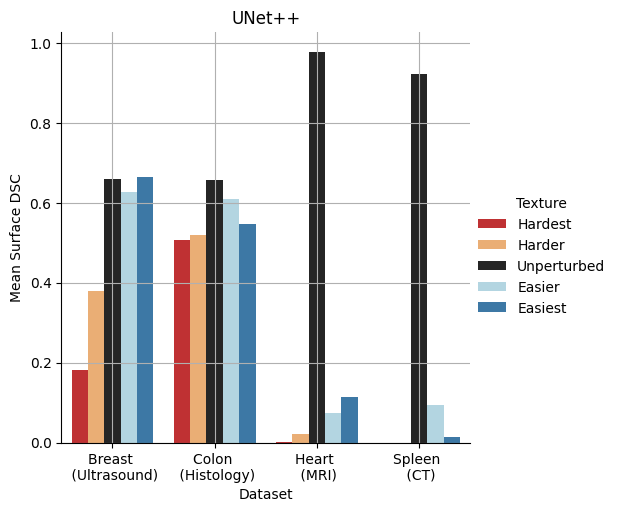

<Figure size 640x480 with 0 Axes>

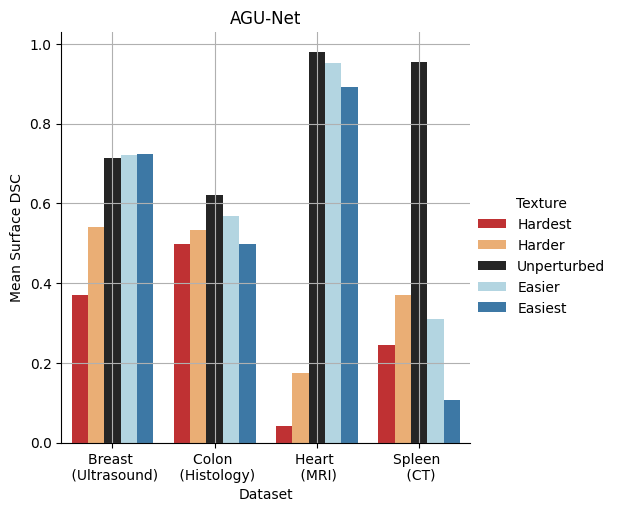

<Figure size 640x480 with 0 Axes>

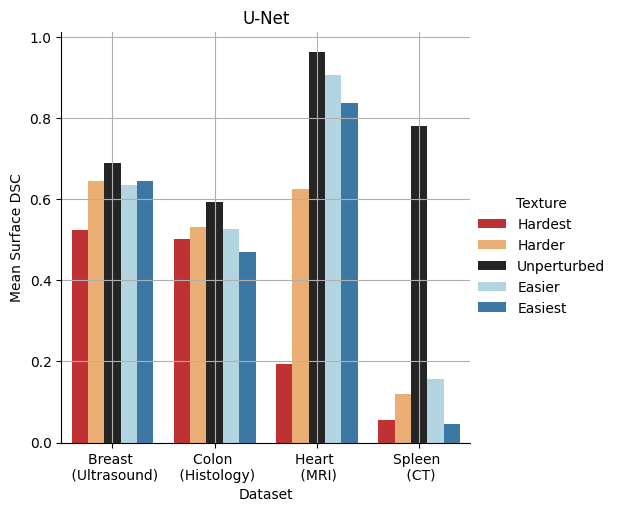

<Figure size 640x480 with 0 Axes>

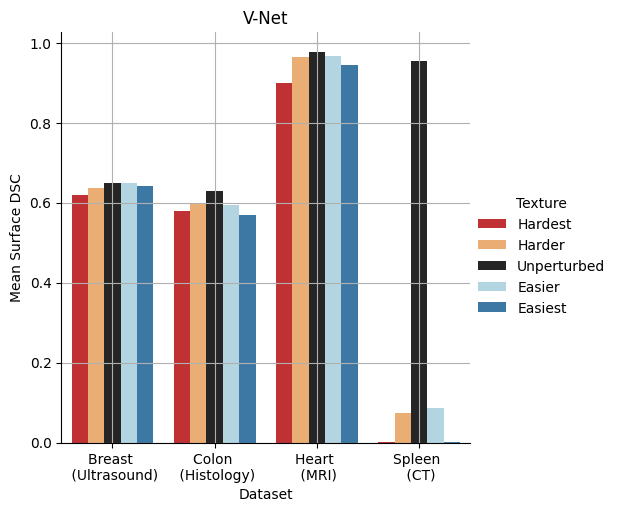

<Figure size 640x480 with 0 Axes>

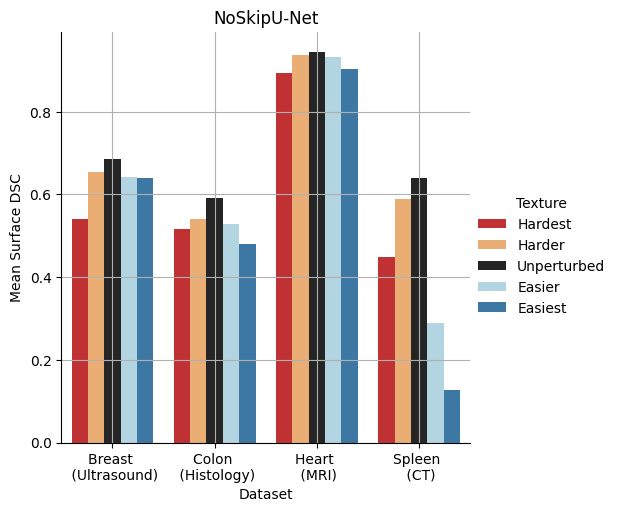

<Figure size 640x480 with 0 Axes>

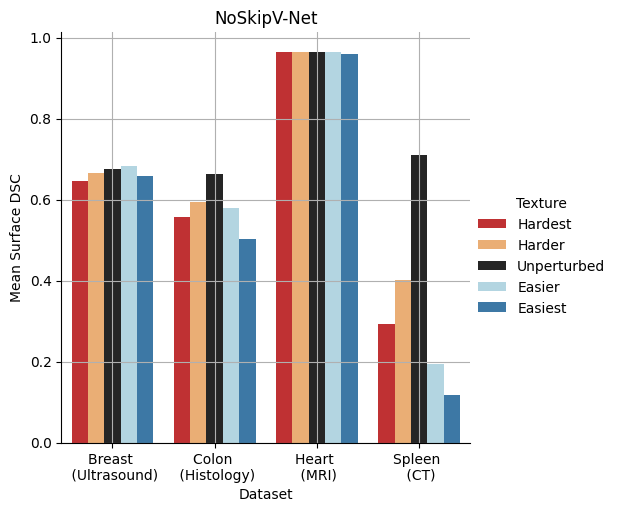

In [5]:
for model_type in model_list:
    data_results = []
    for image_type in anatomy_list:
        for variant in variant_list:
            data_results.append([variant_alias[variant], model_alias[model_type], anatomy_alias[image_type], sdsc_mean_data[variant][model_type][image_type]])


    plt.figure()
    df = pd.DataFrame(data_results, columns=["Texture", "Model", "Dataset", "Mean Surface DSC"])
    sns.catplot(data=df, kind="bar", x="Dataset", y="Mean Surface DSC", hue="Texture", palette=sns.color_palette(['#d7191c', '#fdae61', '#252525', '#abd9e9', '#2c7bb6']))
    plt.title(model_alias[model_type])
    plt.grid(True)